# Backtesting the HMM Model

Signals are identifed by the hmm model and imported into the system. 

    When signal = 1, we enter the mean reversion position.    
    When signal = 0, we enter the momentum position. 


Mean Reversion Strategy:
     
     1.We rank the returns of ETF stocks in the past month
     2.For bottom 3 stock, we buy     
     3.For top 3 stocks, we sell     
     4.We close the position every 10 days 


Momentum Strategy: 

     1.We rank the returns of ETF stocks in the past 8 months
     2.For bottom 3 stock, we buy     
     3.For top 3 stocks, we sell     
     4.We close the position every month 
    
    
    


In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import pandas as pd
from datetime import datetime
import backtrader.analyzers as btanalyzers
import matplotlib.pyplot as plt

In [2]:

class RSI_Oversold(bt.Indicator):
    lines = ('oversold',)
    
    params = (
        ('level', 30),    
    )

    def __init__(self):
        self.lines.oversold = bt.indicators.RSI(self.data) < self.p.level

        
class DummyInd(bt.Indicator):
    lines = ('dummyline',)

    params = (('value', 5),)

    def __init__(self):
        self.lines.dummyline = bt.Max(0.0, self.params.value)

        
# Create a Stratey
class BackTradingStrategy(bt.Strategy):
    params = (
        ('period', 255),
        ("max_days_in_trade", 10)
    )

    def log(self, txt, txt2, txt3, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s, %s, %s' % (dt.isoformat(), txt, txt2, txt3))
        
        
    def read_signals(self):
        signal_data = pd.read_csv("hmm_regime_signals.csv")
        signal_data["datetime"] = signal_data["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))
        signal_data = signal_data.set_index('datetime')
        
        return signal_data
    
    
        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        # How to access individual etf
        self.xlb_close = self.datas[symbols.index("XLB")].close
        self.xle_close = self.datas[symbols.index("XLE")].close
        self.xlf_close = self.datas[symbols.index("XLF")].close
        self.xli_close = self.datas[symbols.index("XLI")].close
        self.xlk_close = self.datas[symbols.index("XLK")].close
        self.xlp_close = self.datas[symbols.index("XLP")].close
        self.xlu_close = self.datas[symbols.index("XLU")].close
        self.xlv_close = self.datas[symbols.index("XLV")].close
        self.xly_close = self.datas[symbols.index("XLY")].close
        
        self.datadate = self.datas[0].datetime.date
        self.days_in_trade = 0
        self.max_days_in_trade_mr = 10
        self.max_days_in_trade_mo = 21
        self.num_mr = 21
        self.num_mo = 21*8
        self.regime_state = 0
        self.mrr = 0.02
        self.mor = 0.05
        self.snum = 3
        self.cash = 1000
        self.signal_data = self.read_signals()
        # keep this 
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)        
        self.symbols = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
        self.regimes = ['momentum', 'mean reversion']
        
        
    def stock_return(self, n):
        """calculate return in the past n days """        
        r_xlb = (self.xlb_close[0] - self.xlb_close[-n])/self.xlb_close[-n]
        r_xle = (self.xle_close[0] - self.xle_close[-n])/self.xle_close[-n]
        r_xlf = (self.xlf_close[0] - self.xlf_close[-n])/self.xlf_close[-n]
        r_xli = (self.xli_close[0] - self.xli_close[-n])/self.xli_close[-n]
        r_xlk = (self.xlk_close[0] - self.xlk_close[-n])/self.xlk_close[-n]
        r_xlp = (self.xlp_close[0] - self.xlp_close[-n])/self.xlp_close[-n]
        r_xlu = (self.xlu_close[0] - self.xlu_close[-n])/self.xlu_close[-n]
        r_xlv = (self.xlv_close[0] - self.xlv_close[-n])/self.xlv_close[-n]
        r_xly = (self.xly_close[0] - self.xly_close[-n])/self.xly_close[-n]
        r_list = [r_xlb, r_xle, r_xlf, r_xli, r_xlk, r_xlp, r_xlu, r_xlv, r_xly]        
        
        df = pd.DataFrame(r_list, index = self.symbols, columns = ['return'])
        
        return df
    
    
    
    def sort_return(self, n):
        """sort return in the past n days in ascending order 
           return the bottom and top 3 return stocks """
        
        df = self.stock_return(n)
        df = df.sort_values(by=['return'])
                
        stock_list = [df.index[0:3].tolist(),df.index[6:].tolist()]
        
        return stock_list
    
    
    
    def check_position(self):
        flag = False
        names = []
        for symbol in self.symbols:
            s_size = self.getposition(data=self.datas[symbols.index(symbol)]).size
            if  s_size != 0:
                flag = True
                names.append(symbol)
        return flag, names
            
    
    
        
    
    def shares_to_buy(self,cash, price):
        """calculate the approximate number of shares to buy given cash to spend and stock price"""
        shares = int(cash/price)
        return shares
    
    
    

    def next(self):
        # Simply log the closing price of the series from the reference               
        
        dt = self.datadate(0).strftime('%Y-%m-%d')
        
        signal = self.signal_data['state'].loc[dt]
        
        position, names = self.check_position()
        
        self.log('regime = %s' % self.regimes[signal], '      HAS Position at %s' % " ".join(names[:3]), ' and  at  %s' %  " ".join(names[3:]))

        
        
        # Check if we are in the market
        if not position:
            # if we do not have a position
            
            if signal == 1:
                """mean reversion"""
                
                stock_list = self.sort_return(self.num_mr)
                # print('stocklist = ', stock_list)
                
                self.log('regime = %s' % self.regimes[signal], 'CREATE BUY  for %s' % " ".join(stock_list[0]), ' SELL for %s' %  " ".join(stock_list[0])) 

                # Buy bottom snum stocks
                for i in range(self.snum):
                    price = self.datas[symbols.index(stock_list[0][i])].close[0]
                    shares = self.shares_to_buy(self.cash,price)
                    self.order = self.buy(data = self.datas[symbols.index(stock_list[0][i])], size = shares)
                    
                # Sell top snum stocks    
                for i in range(self.snum):
                    price = self.datas[symbols.index(stock_list[1][i])].close[0]
                    shares = self.shares_to_buy(self.cash,price)
                    self.order = self.sell(data = self.datas[symbols.index(stock_list[1][i])], size = shares)

                self.days_in_trade = 1
                
                self.regime_state = 1
                    
                    
         
            
            else:
                """momentum"""  
                
                stock_list = self.sort_return(self.num_mo)
                # print('stocklist = ', stock_list)
                
                self.log('regime = %s' % self.regimes[signal], '      CREATE SELL for %s' % " ".join(stock_list[0]), ' BUY  for %s' %  " ".join(stock_list[0]))

                # Sell bottom snum stocks
                for i in range(self.snum):
                    price = self.datas[symbols.index(stock_list[0][i])].close[0]
                    shares = self.shares_to_buy(self.cash,price)
                    self.order = self.sell(data = self.datas[symbols.index(stock_list[0][i])], size = shares)
                    
                # Buy top snum stocks    
                for i in range(self.snum):
                    price = self.datas[symbols.index(stock_list[1][i])].close[0]
                    shares = self.shares_to_buy(self.cash,price)
                    self.order = self.buy(data = self.datas[symbols.index(stock_list[1][i])], size = shares)
                    
                self.days_in_trade = 1
                
                self.regime_state = 0
                    
            
                
            

        else:
            # if we have a position
            
            self.days_in_trade += 1
            
            """mean reversion"""
            if (self.regime_state == 1):
            
                # close the position if regime shift or after holding it for max_mr days.
                if signal == 0 or self.days_in_trade == self.max_days_in_trade_mr:
                    num = len(names)
                    for i in range(num):
                        self.close(data=self.datas[symbols.index(names[i])])
                    
                    self.log('regime = %s' % self.regimes[signal], 'CLOSE Position  %s' % " ".join(names[:3]), ' and for  %s' %  " ".join(names[3:]))
                    self.days_in_trade = 0                    
                    self.regime_state = 0 
                    
            
            """momentum"""
            if (self.regime_state == 0):
                
                # close the position if regime shift or after holding it for max_mo days.
                if signal == 1 or self.days_in_trade == self.max_days_in_trade_mo:
                    num = len(names)
                    for i in range(num):
                        self.close(data=self.datas[symbols.index(names[i])])
                    
                    self.log('regime = %s' % self.regimes[signal], '      CLOSE Position  %s' % " ".join(names[:3]), ' and for  %s' %  " ".join(names[3:]))
                    self.days_in_trade = 0                        
                    self.regime_state = 1
                 
       


In [3]:


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()   

    symbols = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
    for symbol in symbols:
        datapath = os.path.join('../../../datas/%s.csv' % symbol)

        # Create a Data Feed
        data = bt.feeds.YahooFinanceCSVData(
            dataname=datapath,
            # Do not pass values before this date
            fromdate=datetime(2013, 2, 11),
            # Do not pass values before this date
            todate=datetime(2018, 2, 9),
            # Do not pass values after this date
            reverse=False)

        # Add the Data Feed to Cerebro
        cerebro.adddata(data, name=symbol)


    # Add a strategy
    cerebro.addstrategy(BackTradingStrategy) #, symbols= symbols)
    
    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Write output
    cerebro.addwriter(bt.WriterFile, out='0410-ETFbacktesting-8m.csv',csv=True) 
    
    
    # Analyzer
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(btanalyzers.TimeDrawDown, _name='DrawDown')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='TA')

    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    # cerebro.run()
    thestrats = cerebro.run()
    thestrat = thestrats[0]

    # Print out the final result
    print('\nFinal Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    # Print out sharpe ratio and statistics
    print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
    print('Max Draw Down:', thestrat.analyzers.DrawDown.get_analysis(), "\n")
    
    for k,v in thestrat.analyzers.TA.get_analysis().items():
        print(k, ":", v, "\n")
    

Starting Portfolio Value: 100000.00
2014-02-13, regime = momentum,       HAS Position at ,  and  at  
2014-02-13, regime = momentum,       CREATE SELL for XLP XLE XLU,  BUY  for XLP XLE XLU
2014-02-14, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-18, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-19, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-20, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-21, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-24, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-25, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-26, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-27, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2014-02-28, regime

2014-09-11, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-12, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-12, regime = momentum,       CLOSE Position  XLB XLI XLK,  and for  XLP XLV XLY
2014-09-15, regime = momentum,       HAS Position at ,  and  at  
2014-09-15, regime = momentum,       CREATE SELL for XLY XLI XLF,  BUY  for XLY XLI XLF
2014-09-16, regime = momentum,       HAS Position at XLF XLI XLK,  and  at  XLU XLV XLY
2014-09-17, regime = momentum,       HAS Position at XLF XLI XLK,  and  at  XLU XLV XLY
2014-09-18, regime = momentum,       HAS Position at XLF XLI XLK,  and  at  XLU XLV XLY
2014-09-19, regime = momentum,       HAS Position at XLF XLI XLK,  and  at  XLU XLV XLY
2014-09-22, regime = momentum,       HAS Position at XLF XLI XLK,  and  at  XLU XLV XLY
2014-09-23, regime = momentum,       HAS Position at XLF XLI XLK,  and  at  XLU XLV XLY
2014-09-24, regime = momentum,       HAS Position at X

2015-04-13, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-14, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-15, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-16, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-17, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-20, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-21, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-22, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-23, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-24, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-27, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2015-04-28, regime = momentum,  

2015-10-26, regime = mean reversion,       HAS Position at XLB XLI XLK,  and  at  XLU XLV XLY
2015-10-27, regime = mean reversion,       HAS Position at XLB XLI XLK,  and  at  XLU XLV XLY
2015-10-28, regime = mean reversion,       HAS Position at XLB XLI XLK,  and  at  XLU XLV XLY
2015-10-29, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLU XLV XLY
2015-10-29, regime = momentum, CLOSE Position  XLB XLI XLK,  and for  XLU XLV XLY
2015-10-30, regime = momentum,       HAS Position at ,  and  at  
2015-10-30, regime = momentum,       CREATE SELL for XLE XLB XLI,  BUY  for XLE XLB XLI
2015-11-02, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2015-11-03, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2015-11-04, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2015-11-05, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2015-11-06, regime = mean reversion,      

2016-04-26, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-04-27, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-04-28, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-04-29, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-05-02, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-05-03, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-05-04, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-05-05, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-05-06, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-05-09, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-05-10, regime = momentum,       HAS Position at XLB XLF XLK,  and  at  XLP XLU XLV
2016-05-11, regime = momentum,  

2016-10-05, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-06, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-07, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-10, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-11, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-12, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-13, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-14, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-17, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-18, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLP XLV XLY
2016-10-18, regime = momentum,       CLOSE Position  XLB XLE XLF,  and for  XLP XLV XLY
2016-10-19, regime = momentum,  

2017-04-19, regime = momentum,       HAS Position at XLF XLI XLK,  and  at  XLP XLU XLV
2017-04-20, regime = momentum,       HAS Position at XLF XLI XLK,  and  at  XLP XLU XLV
2017-04-20, regime = momentum,       CLOSE Position  XLF XLI XLK,  and for  XLP XLU XLV
2017-04-21, regime = momentum,       HAS Position at ,  and  at  
2017-04-21, regime = momentum,       CREATE SELL for XLE XLV XLP,  BUY  for XLE XLV XLP
2017-04-24, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-04-25, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-04-26, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-04-27, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-04-28, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-01, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-02, regime = momentum,       HAS Position at X

2017-11-03, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-06, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-07, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-08, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-09, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-10, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-13, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-14, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-15, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-16, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-17, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2017-11-20, regime = momentum,  

In [4]:
# calculate pnl using excel data
import pandas as pd
import matplotlib.pyplot as plt

dtime = pd.read_csv('datetime.csv')
data = pd.read_csv('0410-ETFbacktesting-8m.csv').fillna(value = 0)
data = data[:1260]

df = data[data.columns[-9:]].copy()
df.columns = symbols
df['datetime'] = dtime[['datetime']].copy()

n = len(df)
df['cumulative_pnl'] = df['XLB']

cpnl = 0.
count_plus = 0
count_minus = 0

for t in range(n):
    pnl = 0.
    for i in range(len(symbols)):
        profit = df[symbols[i]].iloc[t]
        # print('profit = ', profit)
        pnl = pnl + profit
        if (profit > 0.):
            count_plus +=1
        elif (profit < 0.):
            count_minus +=1
         
    cpnl = cpnl + pnl
    # print('cpnl = ', cpnl)
    df['cumulative_pnl'].iloc[t] = cpnl
    


    

/home/project/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
plus_percent = 1.0*count_plus/(count_plus*1.0+count_minus*1.0) 
print('percentage of trading that make positive profits = ', plus_percent)

percentage of trading that make positive profits =  0.5410628019323671


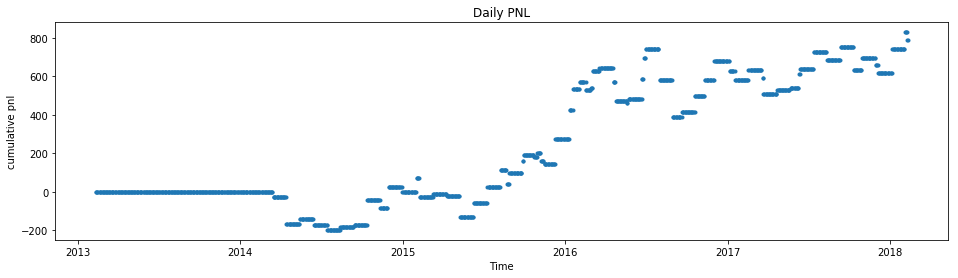

In [6]:
# convert string to datetime
df["datetime"] = df["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))

# plot PNL figures 
plt.figure(figsize=(16, 4))
plt.plot(df['datetime'], df['cumulative_pnl'] ,'.') 
plt.xlabel("Time")
plt.ylabel("cumulative pnl")
plt.title("Daily PNL")
plt.show()

In [7]:
df.to_csv(r'hmm_regime_wealth_8m.csv',header=list(df),index=list(df.index),sep=",",mode="a")

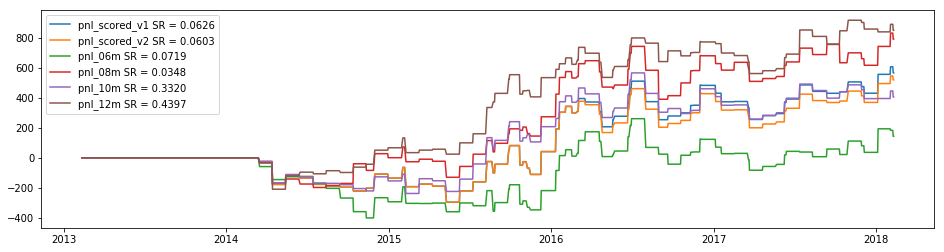

In [2]:
data = pd.read_csv('0410-ETFbacktesting-hmm-pnl.csv')
df = data[:1260]
# convert string to datetime
df["datetime"] = df["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))

# plot figures for pnl of all versions
plt.figure(figsize=(16, 4))
plt.plot(df['datetime'], df['pnl_scored_v1'], label = 'pnl_scored_v1 SR = 0.0626')
plt.plot(df['datetime'], df['pnl_scored_v2'], label = 'pnl_scored_v2 SR = 0.0603')
plt.plot(df['datetime'], df['pnl_6m'], label = 'pnl_06m SR = 0.0719')
plt.plot(df['datetime'], df['pnl_8m'], label = 'pnl_08m SR = 0.0348')
plt.plot(df['datetime'], df['pnl_10m'], label = 'pnl_10m SR = 0.3320')
plt.plot(df['datetime'], df['pnl_12m'], label = 'pnl_12m SR = 0.4397')
plt.legend(loc='best')
plt.show()